In [1]:
import sys 
import cellphonedb
import scanpy as sc

import pandas as pd
import glob
import os

import numpy as np
import seaborn as sns 

import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version)

3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC 12.4.0]


In [2]:
kpy.__version__

'0.3.2'

In [3]:
# -- Version of the databse
cpdb_version = 'v5.0.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('/node200data/18parkky/datasets/reference/z_program_references/cellphoneDB/db', cpdb_version)

from cellphonedb.utils import db_utils

# db_utils.download_database(cpdb_target_dir, cpdb_version)

In [4]:
dict_PatientID_to_MSI_class = {'SC044': 'MSI-H',
                                'CRC2783': 'MSI-I',
                                'SC035': 'MSI-I',
                                'CRC2817': 'MSI-L',

                                'P04': 'MSI-H',
                                'P21': 'MSI-H',
                                'P23': 'MSI-H',
                                
                                'P15': 'MSI-I',
                                'P19': 'MSI-I',
                                'P20': 'MSI-I',
                                'P22': 'MSI-I',
                                'P26': 'MSI-I',
                                
                                'P17': 'MSI-L',
                                'P18': 'MSI-L'}

# Chen

In [5]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.AuthorAnnot.MSI_score_labeled.h5ad')
adata.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PatientID] for PatientID in adata.obs['PatientID'] ]

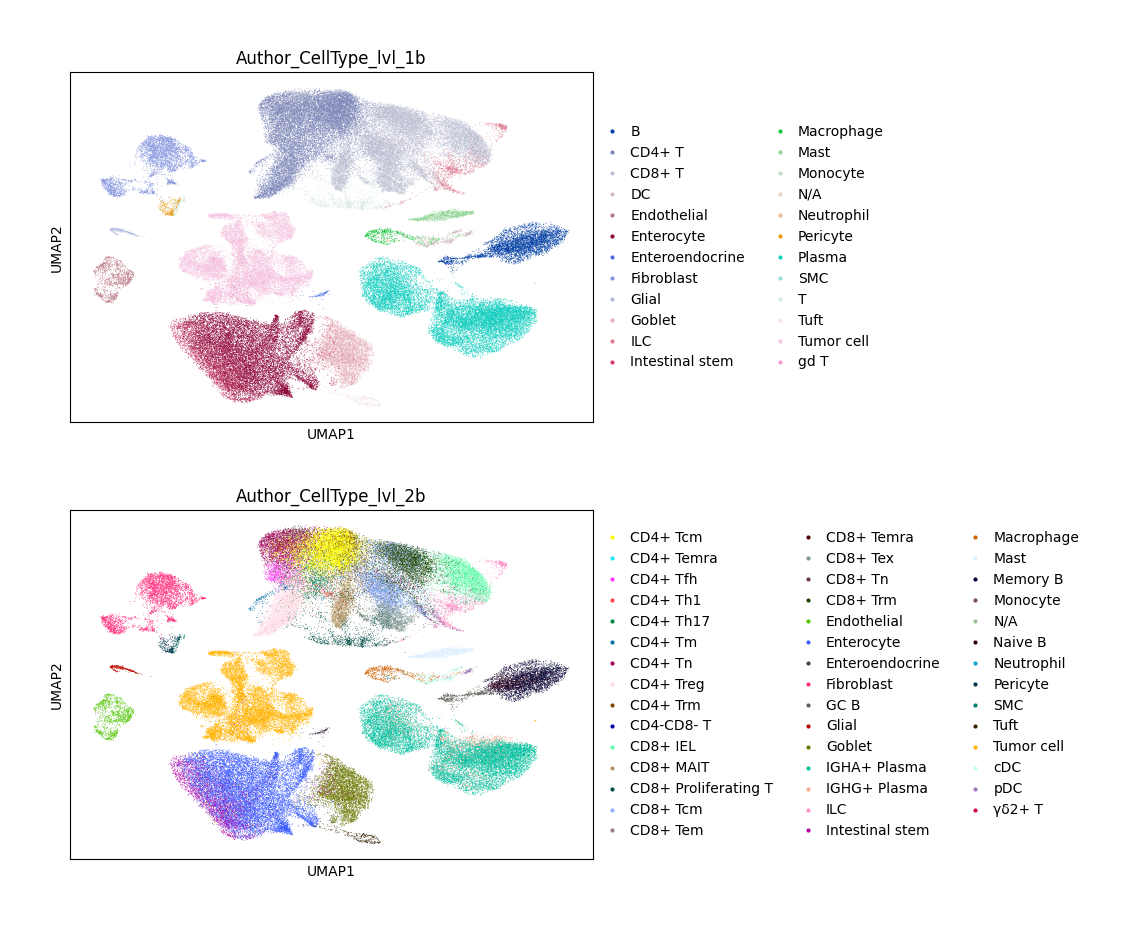

In [6]:
sc.pl.umap(adata, color=['Author_CellType_lvl_1b', 'Author_CellType_lvl_2b'], ncols=1,)

In [7]:
adata_tumor = adata[(adata.obs['BiopsySite']=='Tumor') & (adata.obs['Author_CellType_lvl_1b']!='N/A')].copy()

## Cellphone DB - Method 2 - lvl 1b - No TF

In [8]:
DIR_workspace = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b'

In [9]:
DIR_workspace = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b'
if os.path.exists(DIR_workspace)==False: os.mkdir(DIR_workspace)

cpdb_file_path      = f'{cpdb_target_dir}/cellphonedb.zip'
meta_file_path      = f'{DIR_workspace}/metadata.tsv'                   # path to the meta file linking cell barcodes to cluster labels.
counts_file_path    = f'{DIR_workspace}/normalised_log_counts.h5ad'     # paths to normalized counts file
microenvs_file_path = f'{DIR_workspace}/microenvironment.tsv'           # path to microenvironment file that groups cell types/clusters by microenvironments. 
                                                                        # When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within the microenvironment.
out_path            = f'{DIR_workspace}'

### Prepare input data

In [10]:
# 1. metadata.tsv
for MSI_class, edf in adata_tumor.obs.groupby('MSI_class', observed=True):

    DIR_out = f'{out_path}/{MSI_class}'
    if os.path.exists(DIR_out)==False: os.mkdir( DIR_out )
    else: 
        print(f'{MSI_class} folder already exists! Skipping.')
        continue
    
    metadata = list()
    for tup in edf.itertuples():
        metadata.append( [tup.Index, tup.Author_CellType_lvl_2b] )
    metadata = pd.DataFrame(metadata, columns=['barcode_sample', 'cell_type'])
    
    PATH_metadata = f'{DIR_out}/metadata.{MSI_class}.tsv'
    metadata.to_csv(PATH_metadata, sep='\t', index=False)

In [11]:
# 2. normalised_log_counts.h5ad
for MSI_class in set(adata_tumor.obs['MSI_class']):

    adata_tumor_cpdb = adata_tumor[(adata_tumor.obs['MSI_class']==MSI_class)].raw.to_adata()
    sc.pp.normalize_total(adata_tumor_cpdb)
    sc.pp.log1p(adata_tumor_cpdb)
    
    DIR_out = f'{out_path}/{MSI_class}'
    PATH_cpdb_counts = f'{DIR_out}/normalised_log_counts.{MSI_class}.h5ad'
    adata_tumor_cpdb.write(PATH_cpdb_counts)

In [11]:
# # 3. microenvs.txt (limit interaction search by patient ID)
# for MSI_class, edf in adata_tumor.obs.groupby('MSI_class', observed=True):

#     DIR_out = f'{out_path}/{MSI_class}'
    
#     microenvs = list()
#     for tup in edf.itertuples():
#         microenvs.append( [tup.Index, tup.PatientID] )
#     microenvs = pd.DataFrame(microenvs, columns=['barcode_sample', 'microenvironment'])
    
#     PATH_metadata = f'{DIR_out}/microenvs.{MSI_class}.tsv'
#     microenvs.to_csv(PATH_metadata, sep='\t', index=False)

### Run cellphonedb

In [12]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

for MSI_class in set(adata_tumor.obs['MSI_class']):
    print(MSI_class, flush=True)
    
    PATH_cpdb_counts = f'{out_path}/{MSI_class}/normalised_log_counts.{MSI_class}.h5ad'
    PATH_metadata   = f'{out_path}/{MSI_class}/metadata.{MSI_class}.tsv'
    # PATH_microenvs  = f'{out_path}/{MSI_class}/microenvs.{MSI_class}.tsv'

    cpdb_results = cpdb_statistical_analysis_method.call(
        cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
        meta_file_path = PATH_metadata,                 # mandatory: tsv file defining barcodes to cell label.
        counts_file_path = PATH_cpdb_counts,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
        counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
        # active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
        # microenvs_file_path = PATH_microenvs,       # optional (default: None): defines cells per microenvironment.
        score_interactions = True,                       # optional: whether to score interactions or not. 
        iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
        threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
        threads = 36,                                    # number of threads to use in the analysis.
        debug_seed = 42,                                 # debug randome seed. To disable >=0.
        result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
        pvalue = 0.05,                                   # P-value threshold to employ for significance.
        subsampling = False,                             # To enable subsampling the data (geometri sketching).
        subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
        subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
        subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
        separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
        debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
        output_path = f'{out_path}/{MSI_class}',         # Path to save results.
        output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
        )

MSI-L
Reading user files...
The following user files were loaded successfully:
/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-L/normalised_log_counts.MSI-L.h5ad
/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-L/metadata.MSI-L.tsv
[ ][CORE][03/04/25-12:46:04][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:36 Precision:3
[ ][CORE][03/04/25-12:46:04][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][03/04/25-12:46:06][INFO] Running Real Analysis
[ ][CORE][03/04/25-12:46:06][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [01:56<00:00,  8.57it/s]


[ ][CORE][03/04/25-12:48:06][INFO] Building Pvalues result
[ ][CORE][03/04/25-12:48:10][INFO] Building results
[ ][CORE][03/04/25-12:48:10][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 38/38 [00:00<00:00, 212.64it/s]

[ ][CORE][03/04/25-12:48:10][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 38/38 [00:00<00:00, 608.75it/s]


[ ][CORE][03/04/25-12:48:11][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1444/1444 [00:49<00:00, 29.35it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-L/statistical_analysis_deconvoluted_04_03_2025_124907.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-L/statistical_analysis_deconvoluted_percents_04_03_2025_124907.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-L/statistical_analysis_means_04_03_2025_124907.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-L/statistical_analysis_pvalues_04_03_2025_124907.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-L/statistical_analysis_significant_means_04_03_2025_124907.

100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]


[ ][CORE][03/04/25-12:53:16][INFO] Building Pvalues result
[ ][CORE][03/04/25-12:53:22][INFO] Building results
[ ][CORE][03/04/25-12:53:22][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 43/43 [00:00<00:00, 122.49it/s]

[ ][CORE][03/04/25-12:53:23][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 43/43 [00:00<00:00, 392.02it/s]


[ ][CORE][03/04/25-12:53:23][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1849/1849 [01:03<00:00, 29.13it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-H/statistical_analysis_deconvoluted_04_03_2025_125436.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-H/statistical_analysis_deconvoluted_percents_04_03_2025_125436.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-H/statistical_analysis_means_04_03_2025_125436.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-H/statistical_analysis_pvalues_04_03_2025_125436.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-H/statistical_analysis_significant_means_04_03_2025_125436.

100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]


[ ][CORE][03/04/25-13:01:20][INFO] Building Pvalues result
[ ][CORE][03/04/25-13:01:26][INFO] Building results
[ ][CORE][03/04/25-13:01:27][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 43/43 [00:00<00:00, 72.42it/s]

[ ][CORE][03/04/25-13:01:28][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 43/43 [00:00<00:00, 236.46it/s]


[ ][CORE][03/04/25-13:01:29][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1849/1849 [01:38<00:00, 18.86it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-I/statistical_analysis_deconvoluted_04_03_2025_130315.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-I/statistical_analysis_deconvoluted_percents_04_03_2025_130315.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-I/statistical_analysis_means_04_03_2025_130315.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-I/statistical_analysis_pvalues_04_03_2025_130315.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/MSI-I/statistical_analysis_significant_means_04_03_2025_130315.

## Analyze results

In [13]:
from cellphonedb.utils import search_utils

In [14]:
import glob

pvals, means, decon = list(), list(), list()

for MSI_class in set(adata.obs['MSI_class']):
    
    adata_tumor_cpdb = sc.read_h5ad(f'{DIR_workspace}/{MSI_class}/normalised_log_counts.{MSI_class}.h5ad')
    PATH_pvals = glob.glob(f'{DIR_workspace}/{MSI_class}/statistical_analysis_pvalues*.txt')[0]
    PATH_means = glob.glob(f'{DIR_workspace}/{MSI_class}/statistical_analysis_significant_means*.txt')[0]
    PATH_decon = glob.glob(f'{DIR_workspace}/{MSI_class}/statistical_analysis_decon*.txt')[0]
    
    pvals_e = pd.read_csv(PATH_pvals, sep='\t')
    pvals_e['MSI_class'] = MSI_class
    means_e = pd.read_csv(PATH_means, sep='\t')
    means_e['MSI_class'] = MSI_class
    decon_e = pd.read_csv(PATH_decon, sep='\t')
    decon_e['MSI_class'] = MSI_class

    pvals.append( pvals_e )
    means.append( means_e )
    decon.append( decon_e )

pvals = pd.concat(pvals)
means = pd.concat(means)
decon = pd.concat(decon)

### Total significant interactions

In [17]:
?kpy.plot_cpdb_heatmap

Signature:
kpy.plot_cpdb_heatmap(
    pvals: pandas.core.frame.DataFrame,
    cell_types: list[str] | None = None,
    degs_analysis: bool = False,
    log1p_transform: bool = False,
    alpha: float = 0.05,
    linewidths: float = 0.5,
    row_cluster: bool = True,
    col_cluster: bool = True,
    low_col: str = '#104e8b',
    mid_col: str = '#ffdab9',
    high_col: str = '#8b0a50',
    cmap: str | matplotlib.colors.ListedColormap | None = None,
    title: str = '',
    return_tables: bool = False,
    symmetrical: bool = True,
    default_sep: str = '|',
    **kwargs,
) -> seaborn.matrix.ClusterGrid | dict
Docstring:
Plot cellphonedb results as total counts of interactions.

Parameters
----------
adata : AnnData
    `AnnData` object with the `.obs` storing the `celltype_key`.
    The `.obs_names` must match the first column of the input `meta.txt` used for `cellphonedb`.
cell_types : list[str] | None, optional
    List of cell types to include in the heatmap. If `None`, all cell typ

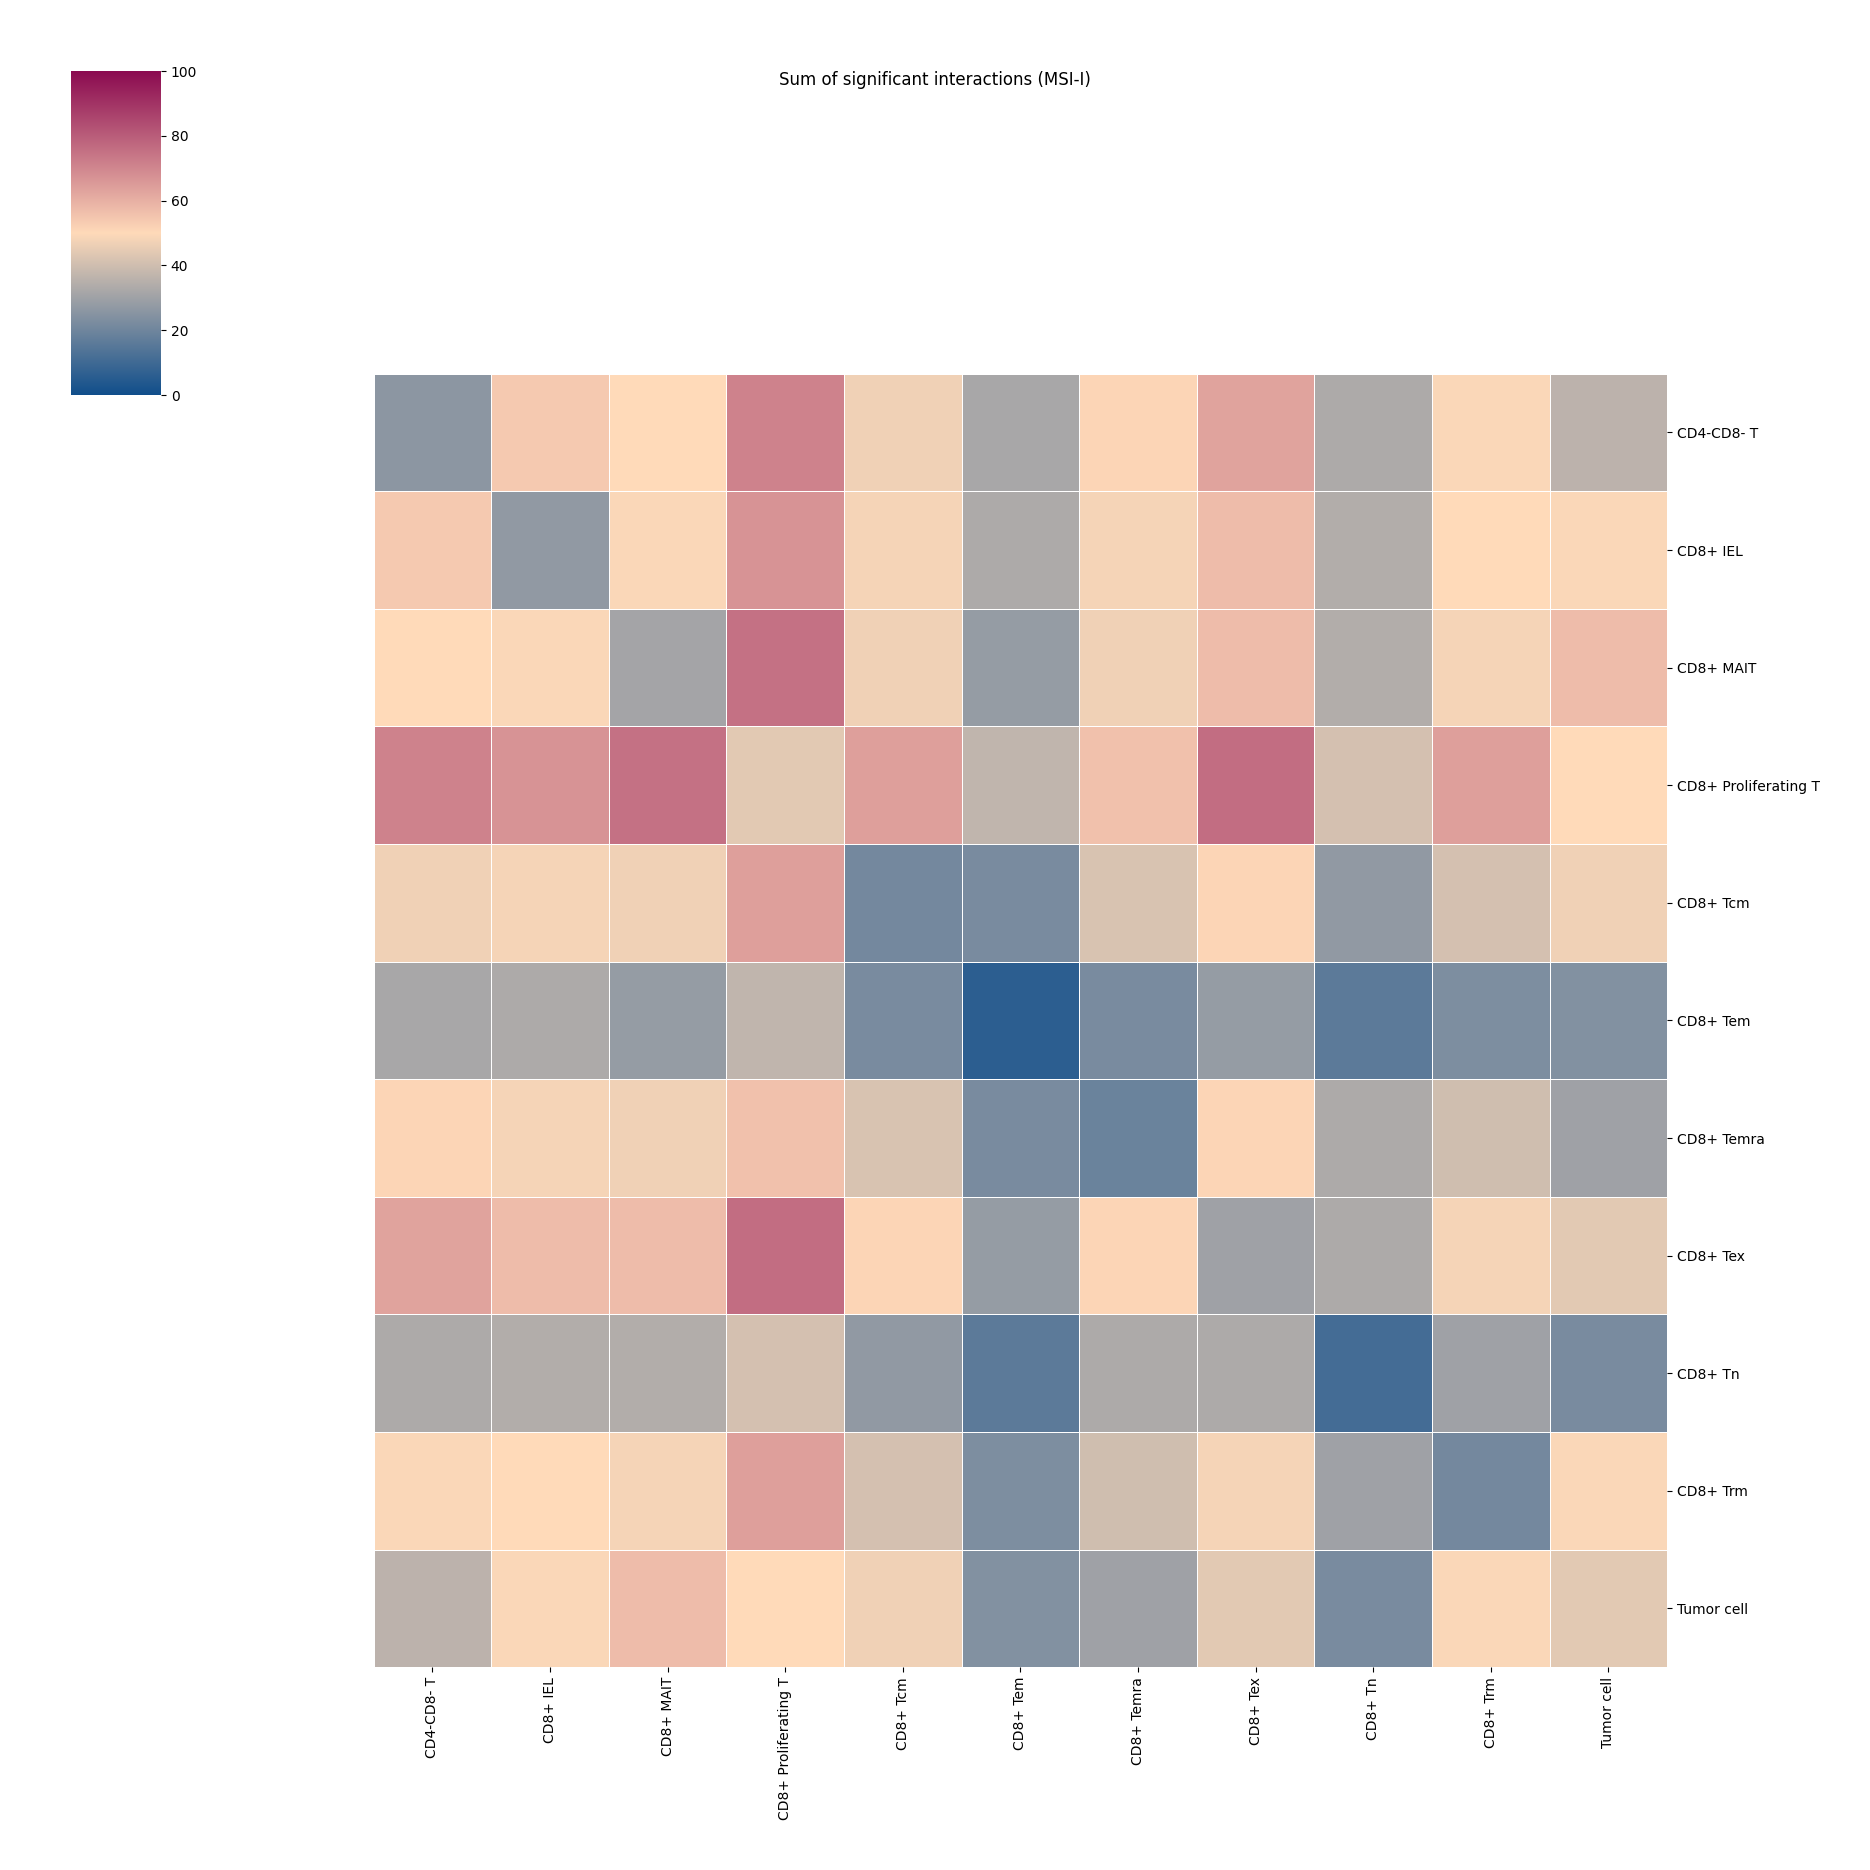

In [29]:
MSI_class_oi = 'MSI-I'

kpy.plot_cpdb_heatmap(pvals=pvals[(pvals['MSI_class']==MSI_class_oi)][[col for col in pvals.columns if col != 'MSI_class']], 
                      row_cluster=False, col_cluster=False,
                    #   vmin=0, vmax=400, 
                      vmin=0, vmax=100, 
                      cell_types=[ct for ct in set(adata.obs['Author_CellType_lvl_2b']) if ('CD8' in ct) or ('Tumor' in ct)],
                      figsize=(18,18), title=f"Sum of significant interactions ({MSI_class_oi})")

### Significant interactions

In [32]:
normal_columns      = list(means.columns)[:14]
cellpair_columns    = [col for col in list(means.columns)[14:] if col !='MSI_class']

In [33]:
means[(means['MSI_class']==MSI_class_oi)][normal_columns]

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,rank
0,CPI-SC06F3DDF90,COL11A1_integrin_a11b1_complex,simple:P12107,complex:integrin_a11b1_complex,COL11A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.001
1,CPI-SC0D3C68BD6,COL17A1_integrin_a11b1_complex,simple:Q9UMD9,complex:integrin_a11b1_complex,COL17A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.001
2,CPI-SC0E40282DA,COL28A1_integrin_a11b1_complex,simple:Q2UY09,complex:integrin_a11b1_complex,COL28A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.001
3,CPI-SC0A5E87289,COL2A1_integrin_a11b1_complex,simple:P02458,complex:integrin_a11b1_complex,COL2A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.001
4,CPI-SC044B5BE16,COL4A5_integrin_a11b1_complex,simple:P29400,complex:integrin_a11b1_complex,COL4A5,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,CPI-SS02A170A99,SPN_SIGLEC1,simple:P16150,simple:Q9BZZ2,SPN,SIGLEC1,True,False,False,curated,False,Ligand-Receptor,NaN,1.516
2532,CPI-SS0DC2DD9D7,THPO_MPL,simple:P40225,simple:P40238,THPO,MPL,True,False,True,curated,False,Ligand-Receptor,NaN,1.516
2533,CPI-SS00F69C501,TRH_TRHR,simple:P20396,simple:P34981,TRH,TRHR,True,False,True,curated,False,Ligand-Receptor,NaN,1.516
2534,CPI-SC0D3C12C3F,COL11A2_integrin_a2b1_complex,simple:P13942,complex:integrin_a2b1_complex,COL11A2,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,1.516


In [37]:
MSI_class_oi = 'MSI-H'

SignificantInteractions = list()

for MSI_class, edf in means.groupby('MSI_class'):
    print(MSI_class)
    for tup in edf.itertuples():
        for idx, cellpair in enumerate(cellpair_columns):
            try: float(list(tup)[14+1+idx])
            except ValueError: continue 
            
            if float(list(tup)[14+1+idx])>0:
                SignificantInteractions.append( [cellpair.split('|')[0], cellpair.split('|')[1], 
                                                tup.id_cp_interaction, tup.interacting_pair, 
                                                tup.gene_a, tup.gene_b,
                                                list(tup)[14+1+idx], MSI_class] )

SignificantInteractions = pd.DataFrame(SignificantInteractions, columns=['CellA', 'CellB', 'id_cp_interaction', 'interacting_pair', 'GeneA', 'GeneB', 'mean', 'MSI_class'])

MSI-H
MSI-I
MSI-L


In [59]:
ImmuneCellTypes = list()
for ct in sorted(list(set(adata_tumor.obs['Author_CellType_lvl_2b']))):
    if ('CD4' in ct) or ('CD8' in ct) or (ct in ['Macrophage', 'Monocyte', 'Neutrophil', 'γδ2+ T', 'Memory B', 'Naive B', 'GC B', 'pDC', 'cDC']) or ('Plasma' in ct):
        ImmuneCellTypes.append( ct )
    else:
        print(ct)

Endothelial
Enterocyte
Enteroendocrine
Fibroblast
Glial
Goblet
ILC
Intestinal stem
Mast
Pericyte
SMC
Tuft
Tumor cell


In [144]:
means

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,pDC|Enterocyte,pDC|Enteroendocrine,pDC|GC B,pDC|Glial,pDC|Goblet,γδ2+ T|Enterocyte,γδ2+ T|Enteroendocrine,γδ2+ T|GC B,γδ2+ T|Glial,γδ2+ T|Goblet
0,CPI-SS0EC8C81E0,VEGFC_KDR,simple:P49767,simple:P35968,VEGFC,KDR,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPI-SC06F3DDF90,COL11A1_integrin_a11b1_complex,simple:P12107,complex:integrin_a11b1_complex,COL11A1,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPI-SC015ED6B05,COL22A1_integrin_a11b1_complex,simple:Q8NFW1,complex:integrin_a11b1_complex,COL22A1,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPI-SC08885876E,COL26A1_integrin_a11b1_complex,simple:Q96A83,complex:integrin_a11b1_complex,COL26A1,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPI-SS08719F19E,APELA_APLNR,simple:P0DMC3,simple:P35414,APELA,APLNR,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,CPI-SS02A170A99,SPN_SIGLEC1,simple:P16150,simple:Q9BZZ2,SPN,SIGLEC1,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2532,CPI-SS0DC2DD9D7,THPO_MPL,simple:P40225,simple:P40238,THPO,MPL,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2533,CPI-SS00F69C501,TRH_TRHR,simple:P20396,simple:P34981,TRH,TRHR,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2534,CPI-SC0D3C12C3F,COL11A2_integrin_a2b1_complex,simple:P13942,complex:integrin_a2b1_complex,COL11A2,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
MSI_class_oi = 'MSI-L'

genes_of_interest = [
    # Immune Activation (Stimulatory Interactions)
    "CD80", "CD86", "CD28", "ICOSLG", "ICOS", "CD40", "CD40LG", "TNFRSF9", "TNFSF9",
    # "IL2", "IL7", "IL12A", "IL12B", "IL15", "IL21", "IFNG",
    # "HLA-A", "HLA-B", "HLA-C", "HLA-DRA", "HLA-DQ", "HLA-DP",
    # "CD3E", "CD3D", "CD3G",

    # # Immune Suppression (Inhibitory Interactions)
    # "PDCD1", "CD274", "PDCD1LG2", "CTLA4", "LAG3", "HAVCR2", "TIGIT", "VSIR",
    # "FOXP3", "IL10", "TGFB1",
    # "ARG1", "IDO1", "CD163", "CSF1R",

    # # T Cell-Mediated Cell Death (Cytotoxicity)
    # "PRF1", "GZMA", "GZMB", "GZMK",
    # "FAS", "FASLG",
    # "TNFSF10", "TNFRSF10A", "TNFRSF10B",
    # "TNF", "TNFRSF1A"
]

kpy.plot_cpdb(
    adata=sc.read_h5ad(f'{DIR_workspace}/{MSI_class_oi}/normalised_log_counts.{MSI_class_oi}.h5ad'),
    cell_type1="Tumor cell",
    cell_type2="CD8+ Tem",  # this means all cell-types
    means=means[means['MSI_class']==MSI_class_oi].drop('MSI_class', axis=1),
    pvals=pvals[pvals['MSI_class']==MSI_class_oi].drop('MSI_class', axis=1),
    celltype_key="Author_CellType_lvl_2b",
    genes=genes_of_interest,
    figsize=(13, 4),
    title="interacting interactions!",
)

ValueError: The condensed distance matrix must contain only finite values.

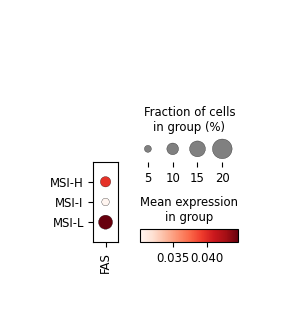

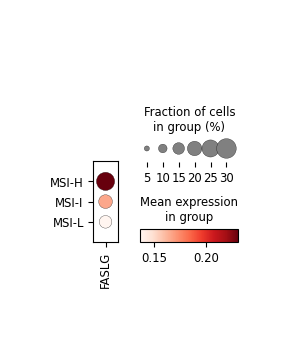

In [134]:
adata_tumor_2 = adata_tumor.raw.to_adata()

sc.pp.normalize_total(adata_tumor_2)
sc.pp.log1p(adata_tumor_2)

sc.pl.dotplot(adata_tumor_2[(adata_tumor_2.obs['Author_CellType_lvl_1b'].isin(['Tumor cell',]))], 
              var_names=['FAS'], groupby='MSI_class')
sc.pl.dotplot(adata_tumor_2[(adata_tumor_2.obs['Author_CellType_lvl_1b'].isin(['CD8+ T',]))], 
              var_names=['FASLG'], groupby='MSI_class')

In [127]:
means[means['gene_b']=='FAS']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,pDC|Enterocyte,pDC|Enteroendocrine,pDC|GC B,pDC|Glial,pDC|Goblet,γδ2+ T|Enterocyte,γδ2+ T|Enteroendocrine,γδ2+ T|GC B,γδ2+ T|Glial,γδ2+ T|Goblet
919,CPI-SS0D168412F,FASLG_FAS,simple:P48023,simple:P25445,FASLG,FAS,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,CPI-SS0D168412F,FASLG_FAS,simple:P48023,simple:P25445,FASLG,FAS,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715,CPI-SS0D168412F,FASLG_FAS,simple:P48023,simple:P25445,FASLG,FAS,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155,NaN,NaN


In [131]:
SignificantInteractions[(SignificantInteractions['GeneB']=='FAS') & (SignificantInteractions['CellB']=='Tumor cell')]

,CellA,CellB,id_cp_interaction,interacting_pair,GeneA,GeneB,mean,MSI_class,cell_pair
105954,CD8+ IEL,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.200,MSI-L,CD8+ IEL_Tumor cell
105977,CD8+ Proliferating T,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.091,MSI-L,CD8+ Proliferating T_Tumor cell
105999,CD8+ Tcm,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.125,MSI-L,CD8+ Tcm_Tumor cell
106024,CD8+ Tem,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.190,MSI-L,CD8+ Tem_Tumor cell
106049,CD8+ Temra,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.312,MSI-L,CD8+ Temra_Tumor cell
106070,CD8+ Tex,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.109,MSI-L,CD8+ Tex_Tumor cell
106095,CD8+ Trm,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.143,MSI-L,CD8+ Trm_Tumor cell
106120,ILC,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.186,MSI-L,ILC_Tumor cell
106145,γδ2+ T,Tumor cell,CPI-SS0D168412F,FASLG_FAS,FASLG,FAS,0.211,MSI-L,γδ2+ T_Tumor cell


<Axes: xlabel='cell_pair', ylabel='interacting_pair'>

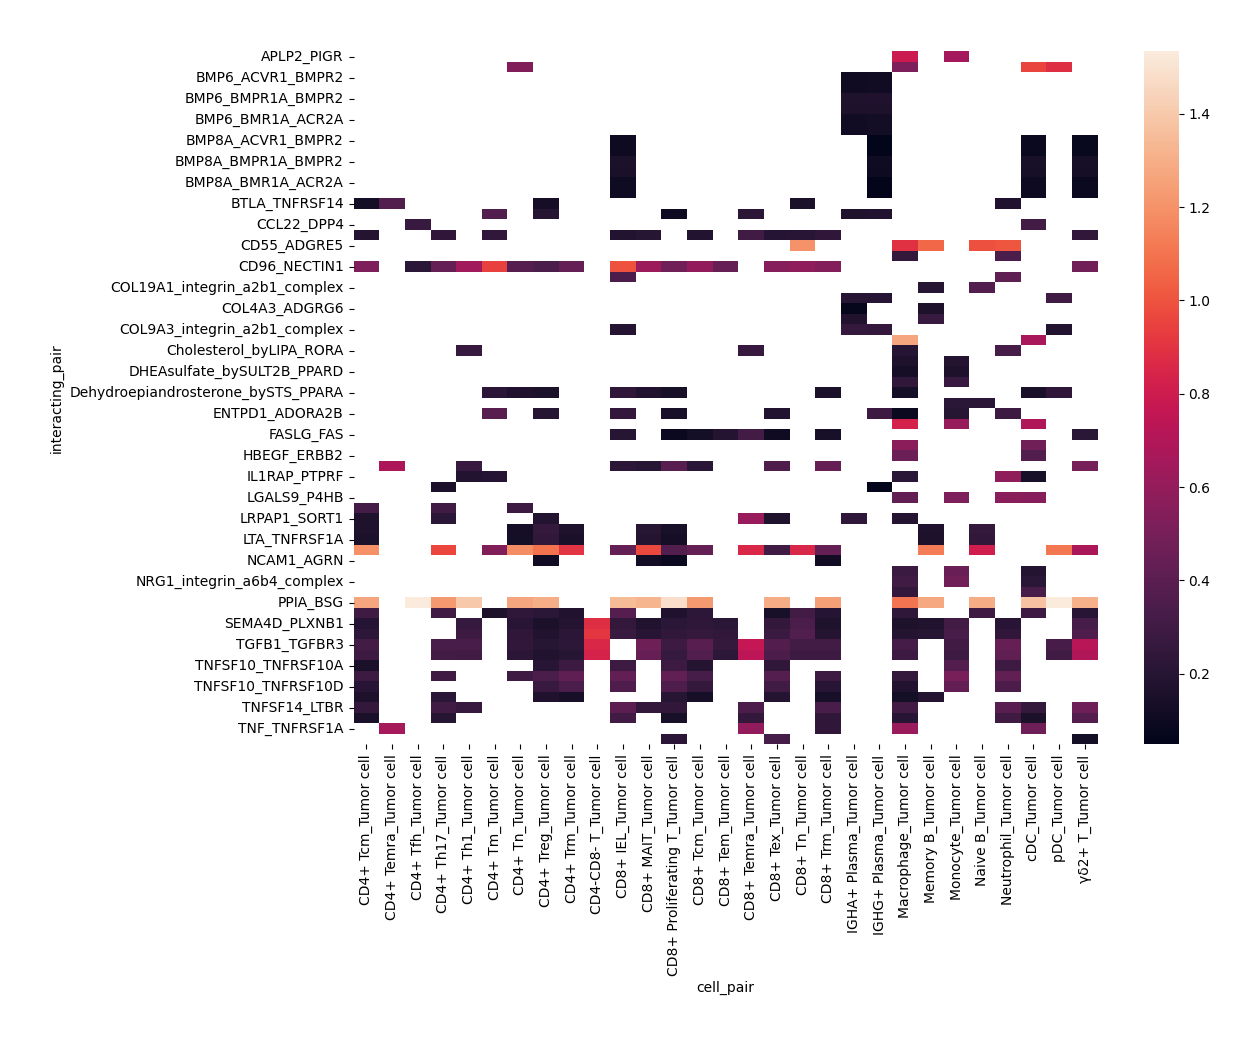

In [100]:
SignificantInteractions['cell_pair'] = [ f'{tup.CellA}_{tup.CellB}' for tup in SignificantInteractions.itertuples()  ]

SignificantInteractions_pivot = SignificantInteractions[(SignificantInteractions['MSI_class']=='MSI-L') & 
                                                        (SignificantInteractions['CellA'].isin( ImmuneCellTypes )) & 
                                                        (SignificantInteractions['CellB'].isin(['Tumor cell']))].pivot( columns='interacting_pair', index='cell_pair', values='mean' )


interaction_of_interest = list()
for tup in SignificantInteractions_pivot.T.itertuples():
    interaction = list(tup)[0]
    means_values = list(tup)[1:]
    nan_count = 0 
    for entry in means_values:
        if bool(entry>0) == False:
            nan_count += 1
    if nan_count >= int(len(means_values)*0.99):
        continue 
    else:
        interaction_of_interest.append(interaction)


SignificantInteractions_pivot = SignificantInteractions[(SignificantInteractions['MSI_class']=='MSI-L') & 
                                                        (SignificantInteractions['CellA'].isin( ImmuneCellTypes )) & 
                                                        (SignificantInteractions['interacting_pair'].isin(interaction_of_interest)) & 
                                                        (SignificantInteractions['CellB'].isin(['Tumor cell']))].pivot( columns='interacting_pair', index='cell_pair', values='mean' )

plt.figure(figsize=(12, 9))
sns.heatmap(SignificantInteractions_pivot.T)


In [91]:
SignificantInteractions_pivot.T

cell_pair,CD4+ Tcm_CD4+ Tcm,CD4+ Tcm_CD4+ Temra,CD4+ Tcm_CD4+ Tfh,CD4+ Tcm_CD4+ Th1,CD4+ Tcm_CD4+ Th17,CD4+ Tcm_CD4+ Tm,CD4+ Tcm_CD4+ Tn,CD4+ Tcm_CD4+ Treg,CD4+ Tcm_CD4+ Trm,CD4+ Tcm_CD4-CD8- T,...,γδ2+ T_Monocyte,γδ2+ T_Naive B,γδ2+ T_Neutrophil,γδ2+ T_Pericyte,γδ2+ T_SMC,γδ2+ T_Tuft,γδ2+ T_Tumor cell,γδ2+ T_cDC,γδ2+ T_pDC,γδ2+ T_γδ2+ T
interacting_pair,,,,,,,,,,,,,,,,,,,,,
2arachidonoylglycerol_byDAGLB_CNR2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2arachidonoylglycerol_byDAGLB_GPR55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5alphaDihydroprogesterone_byDHRS9_PGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADM2_RAMP2_complex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADM_RAMP3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
atRetinoicAcid_byALDH1A2_RAreceptor_RXRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
atRetinoicAcid_byALDH1A2_RAreceptor_RXRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b-Endorphin_byPOMC_OPRM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
interaction_of_interest

[]

In [35]:
SignificantInteractions[(SignificantInteractions['interacting_pair']=='CEACAM5_CD8A') & 
                        ((SignificantInteractions['CellA']=='Tumor cell'))].sort_values('mean', ascending=False,).head(20)

,CellA,CellB,id_cp_interaction,interacting_pair,GeneA,GeneB,mean
10982,Tumor cell,CD8+ Tex,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.988
10981,Tumor cell,CD8+ Temra,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.933
10979,Tumor cell,CD8+ Tcm,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.880
10980,Tumor cell,CD8+ Tem,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.822
10983,Tumor cell,CD8+ Tn,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.812
10984,Tumor cell,CD8+ Trm,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.805
10977,Tumor cell,CD8+ MAIT,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.766
10978,Tumor cell,CD8+ Proliferating T,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.571
10976,Tumor cell,CD8+ IEL,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.414
10985,Tumor cell,ILC,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.287


In [136]:
SignificantInteractions[((SignificantInteractions['CellA']=='Tumor cell')) | 
                        ((SignificantInteractions['CellB']=='Tumor cell'))]

,CellA,CellB,id_cp_interaction,interacting_pair,GeneA,GeneB,mean
1,Enteroendocrine,Tumor cell,CPI-CS033DE552A,SerotoninDopamin_byDDC_HTR3C,NaN,HTR3C,0.308
2,Enteroendocrine,Tumor cell,CPI-CS096413347,SerotoninDopamin_byDDC_HTR3E,NaN,HTR3E,0.442
33,T,Tumor cell,CPI-SC0F4F95585,IL26_IL26_receptor,IL26,NaN,0.062
81,Glial,Tumor cell,CPI-SS04FD52559,TENM3_ADGRL1,TENM3,ADGRL1,0.244
84,Pericyte,Tumor cell,CPI-SS0B0B67CA2,NRXN2_ADGRL1,NRXN2,ADGRL1,0.069
...,...,...,...,...,...,...,...
16526,Macrophage,Tumor cell,CPI-SS0E2453044,PPIA_BSG,PPIA,BSG,0.950
16547,Pericyte,Tumor cell,CPI-SS0E2453044,PPIA_BSG,PPIA,BSG,1.191
16565,SMC,Tumor cell,CPI-SS0E2453044,PPIA_BSG,PPIA,BSG,1.194
16583,T,Tumor cell,CPI-SS0E2453044,PPIA_BSG,PPIA,BSG,1.323


In [114]:
SignificantInteractions[(SignificantInteractions['interacting_pair']=='PVR_TIGIT') & 
                        ((SignificantInteractions['CellA']=='Tumor cell') & 
                         (SignificantInteractions['CellB']=='CD8+ T'))].sort_values('mean', ascending=False,).head(20)

,CellA,CellB,id_cp_interaction,interacting_pair,GeneA,GeneB,mean
5625,Tumor cell,CD8+ T,CPI-SS00561BBD7,PVR_TIGIT,PVR,TIGIT,0.331


In [118]:
SignificantInteractions[(SignificantInteractions['interacting_pair']=='CEACAM5_CD8A') & 
                        ((SignificantInteractions['CellA']=='Tumor cell') & 
                         (SignificantInteractions['CellB']=='CD8+ T'))].sort_values('mean', ascending=False,).head(20)

,CellA,CellB,id_cp_interaction,interacting_pair,GeneA,GeneB,mean
3288,Tumor cell,CD8+ T,CPI-SS04B37190C,CEACAM5_CD8A,CEACAM5,CD8A,0.831


In [13]:
MSI_class_oi = 'MSI-L'

kpy.plot_cpdb(
    adata=adata,
    cell_type1="Tumor cell",
    cell_type2=".",  # this means all cell-types
    means=means[(means['MSI_class']==MSI_class_oi)][[col for col in means.columns if col != 'MSI_class']],
    pvals=pvals[(pvals['MSI_class']==MSI_class_oi)][[col for col in pvals.columns if col != 'MSI_class']],
    celltype_key="Author_CellType_lvl_1b ",
    genes=["PTPRC", "TNFSF13B"],
    figsize=(13, 4),
    title="interacting interactions!",
)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,Tumor cell|Glial,Tumor cell|Goblet,gd T|Enterocyte,gd T|Enteroendocrine,gd T|Glial,gd T|Goblet,nan|Enterocyte,nan|Enteroendocrine,nan|Glial,nan|Goblet
0,CPI-CS0D17EA793,Adenosine_byNT5E_and_SLC29A3_ADORA2B,complex:Adenosine_byNT5E_and_SLC29A3,simple:P29275,NaN,ADORA2B,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPI-SC008D5E4B2,COL26A1_integrin_a10b1_complex,simple:Q96A83,complex:integrin_a10b1_complex,COL26A1,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPI-SC0AA500B63,COL22A1_integrin_a10b1_complex,simple:Q8NFW1,complex:integrin_a10b1_complex,COL22A1,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPI-SS05162C56B,NTF3_NTRK3,simple:P20783,simple:Q16288,NTF3,NTRK3,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPI-SC0423059DF,COL19A1_integrin_a10b1_complex,simple:Q14993,complex:integrin_a10b1_complex,COL19A1,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,CPI-CC0E019A0C0,Glutamate_byGLS2_and_SLC17A8_Glutamate_Kainate...,complex:Glutamate_byGLS2_and_SLC17A8,complex:Glutamate_Kainate_3_4_complex,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2406,CPI-CC00FD66B07,Glutamate_byGLS2_and_SLC17A7_Glutamate_Kainate...,complex:Glutamate_byGLS2_and_SLC17A7,complex:Glutamate_Kainate_3_4_complex,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2407,CPI-CC02AA64371,Glutamate_byGLS_and_SLC1A7_Glutamate_Kainate_3...,complex:Glutamate_byGLS_and_SLC1A7,complex:Glutamate_Kainate_3_4_complex,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2408,CPI-CC03E04AA64,Glutamate_byGLS_and_SLC1A2_Glutamate_Kainate_3...,complex:Glutamate_byGLS_and_SLC1A2,complex:Glutamate_Kainate_3_5_complex,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find interactions that show monotonic changes across MSI-L → MSI-I → MSI-H

In [223]:

def isMonotonic( dict_MSI_class_to_means ):
    import scipy.stats
    spermanr, pval = scipy.stats.spearmanr( [1, 2, 3], [dict_MSI_class_to_means['MSI-L'], dict_MSI_class_to_means['MSI-I'], dict_MSI_class_to_means['MSI-H']] )
    
    if dict_MSI_class_to_means['MSI-L'] < dict_MSI_class_to_means['MSI-I'] < dict_MSI_class_to_means['MSI-H']:
        return True, spermanr, pval
    if dict_MSI_class_to_means['MSI-L'] > dict_MSI_class_to_means['MSI-I'] > dict_MSI_class_to_means['MSI-H']:
        return True, spermanr, pval
    return False, spermanr, pval

CelltypePairs = set(list(means.columns)[14:-1])
interactionSummary = list()

for CelltypePair in CelltypePairs:
    means_oi = means[list(means.columns[:13])+[CelltypePair, 'MSI_class']]
    
    
    for id_cp_interaction, edf in means_oi.fillna(0).groupby('id_cp_interaction', observed=True):
        dict_MSI_class_to_means = { 'MSI-L' : 0, 'MSI-I' : 0, 'MSI-H' : 0, }
        for tup in edf.itertuples(): dict_MSI_class_to_means[tup.MSI_class] = list(tup)[-2]
        
        boolMonotnic, spermanr, pval = isMonotonic( dict_MSI_class_to_means )
        
        if boolMonotnic==True:
            interactionSummary.append( [CelltypePair.split('|')[0], CelltypePair.split('|')[1], id_cp_interaction, edf.iloc[0].interacting_pair, spermanr, pval] )
    
interactionSummary = pd.DataFrame(interactionSummary, columns=['Cell1', 'Cell2', 'id_cp_interaction', 'interacting_pair', 'spermanr', 'pval'])

/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/tmp/ipykernel_23677/1487359366.py:3: ConstantInputWarning: An input array i

In [225]:
interactionSummary['pair'] = [ f'{tup.Cell1}_{tup.Cell2}' for tup in interactionSummary.itertuples() ]
interactionSummary.to_csv('/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/CellphoneDB/interactingSummary.tsv', sep='\t', index=False)

In [300]:
interactionSummary[(interactionSummary['Cell2']=='CD8+ T') & (interactionSummary['Cell1']=='DC')].sort_values('spermanr')

,Cell1,Cell2,id_cp_interaction,interacting_pair,spermanr,pval,pair
4985,DC,CD8+ T,CPI-CS0D69D106B,integrin_aVb1_complex_ADGRE5,-1.0,0.0,DC_CD8+ T
4986,DC,CD8+ T,CPI-SC00035437A,ICAM1_integrin_aLb2_complex,-1.0,0.0,DC_CD8+ T
4987,DC,CD8+ T,CPI-SC03AF43F8B,SEMA7A_integrin_a1b1_complex,-1.0,0.0,DC_CD8+ T
4988,DC,CD8+ T,CPI-SC073A7317A,COL24A1_integrin_a1b1_complex,-1.0,0.0,DC_CD8+ T
4989,DC,CD8+ T,CPI-SC0943ECD6E,ICAM2_integrin_aLb2_complex,-1.0,0.0,DC_CD8+ T
4991,DC,CD8+ T,CPI-SC09DC9200A,ICAM3_integrin_aLb2_complex,-1.0,0.0,DC_CD8+ T
4992,DC,CD8+ T,CPI-SC0E029AB31,PLAUR_integrin_a4b1_complex,-1.0,0.0,DC_CD8+ T
5000,DC,CD8+ T,CPI-SS085EE60B1,TGFB1_TGFBR3,-1.0,0.0,DC_CD8+ T
4998,DC,CD8+ T,CPI-SS07ACDDCD6,APP_SORL1,-1.0,0.0,DC_CD8+ T
5009,DC,CD8+ T,CPI-SS0E9A581F8,ICAM1_ITGAL,-1.0,0.0,DC_CD8+ T


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/ktplotspy/plot/plot_cpdb.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


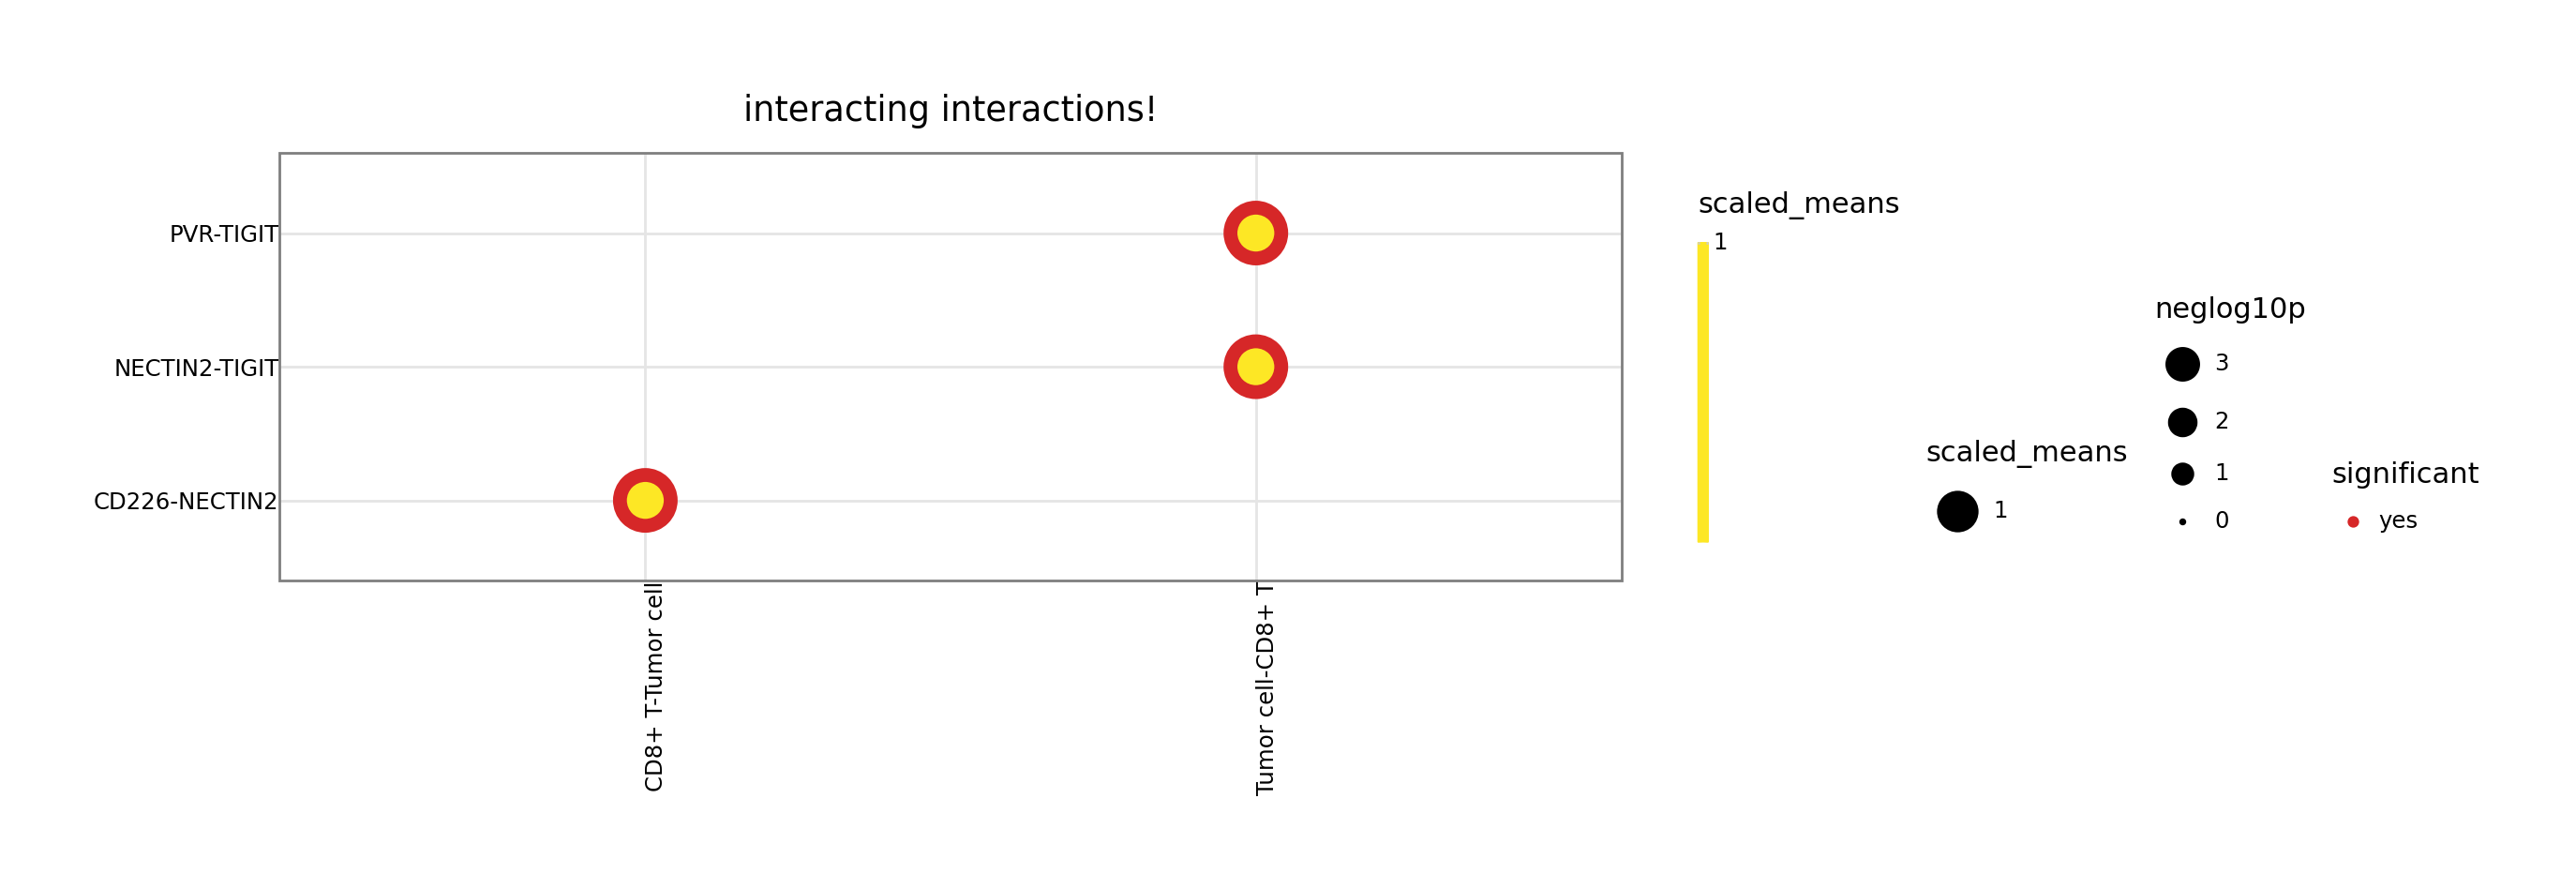

In [301]:
kpy.plot_cpdb(
    adata=adata_tumor_cpdb,
    cell_type1="Tumor",
    cell_type2="CD8+ T",  # this means all cell-types
    means=means_e,
    pvals=pvals_e,
    celltype_key="Author_CellType_lvl_1b",
    genes=["NECTIN2", "TIGIT"],
    figsize=(13, 4),
    title="interacting interactions!",
)

In [272]:
means[means['id_cp_interaction'].isin(['CPI-SS00561BBD7', 'CPI-SS0E14458C9', 'CPI-SS0B1535576'])][['interacting_pair', 'Tumor cell|CD8+ T', 'MSI_class']].sort_values(['interacting_pair', 'MSI_class'])

,interacting_pair,Tumor cell|CD8+ T,MSI_class
648,CXCL16_CXCR6,0.348,MSI-H
552,CXCL16_CXCR6,0.266,MSI-I
802,CXCL16_CXCR6,0.179,MSI-L
718,NECTIN2_TIGIT,0.382,MSI-H
638,NECTIN2_TIGIT,0.390,MSI-I
834,NECTIN2_TIGIT,0.426,MSI-L
543,PVR_TIGIT,0.327,MSI-H
558,PVR_TIGIT,0.331,MSI-I
677,PVR_TIGIT,0.351,MSI-L


<Axes: xlabel='MSI_class', ylabel='interacting_pair'>

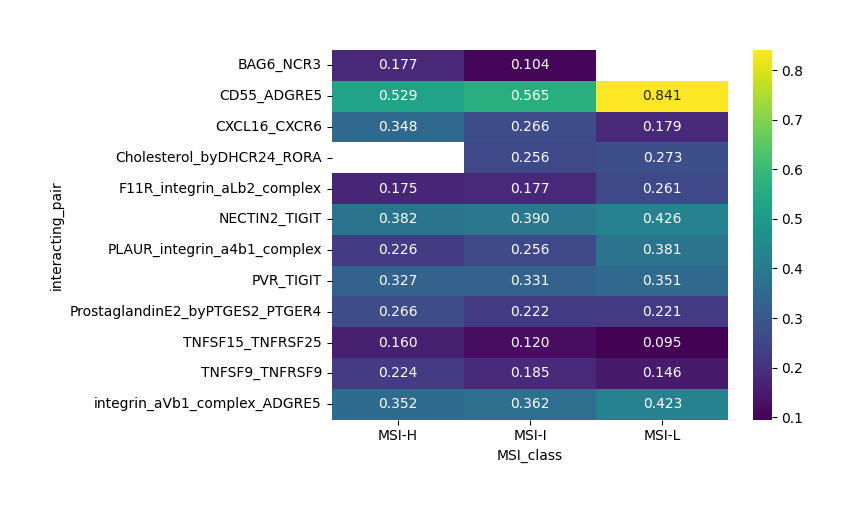

In [290]:
sns.heatmap(means[means['id_cp_interaction'].isin(list(interactionSummary[(interactionSummary['Cell1']=='Tumor cell') & (interactionSummary['Cell2']=='CD8+ T')]['id_cp_interaction']))][['interacting_pair', 'Tumor cell|CD8+ T', 'MSI_class']].pivot( columns='MSI_class', index='interacting_pair', values='Tumor cell|CD8+ T' ),
            annot=True, fmt='.3f', cmap='viridis',)

In [320]:
adata_copy = adata.raw.to_adata()
sc.pp.normalize_total(adata_copy)
sc.pp.log1p(adata_copy)

In [322]:
for gene in adata_copy.var.index:
    if 'HLA' in gene:
        print(gene)

HHLA3
SCHLAP1
HHLA2
HLA-F
HLA-F-AS1
HLA-G
HLA-A
HLA-E
HLA-C
HLA-B
HLA-DRA
HLA-DRB5
HLA-DRB1
HLA-DQA1
HLA-DQB1
HLA-DQB1-AS1
HLA-DQA2
HLA-DQB2
HLA-DOB
HLA-DMB
HLA-DMA
HLA-DOA
HLA-DPA1
HLA-DPB1
HHLA1


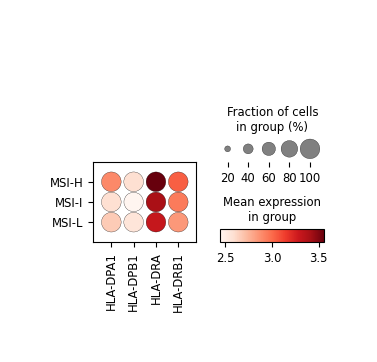

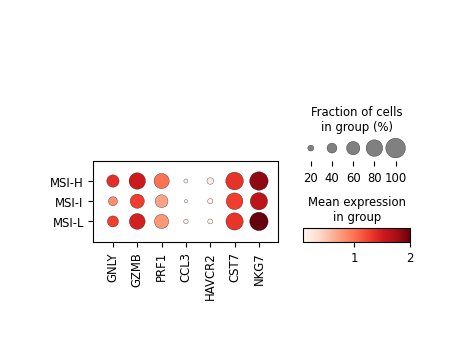

In [341]:
sc.pl.dotplot(adata_copy[(adata_copy.obs['BiopsySite']=='Tumor') & (adata_copy.obs['Author_CellType_lvl_1b']=='DC')], 
              var_names=['HLA-DPA1', 'HLA-DPB1', 'HLA-DRA', 'HLA-DRB1'], groupby='MSI_class', 
              # standard_scale='var',
              
              )


# GNLY
# GZMB
# PRF1
# CCL3
# HAVCR2
# CST7
# IFNG
# NKG7

sc.pl.dotplot(adata_copy[(adata_copy.obs['BiopsySite']=='Tumor') & (adata_copy.obs['Author_CellType_lvl_1b']=='CD8+ T')], 
              var_names=['GNLY', 'GZMB', 'PRF1', 'CCL3', 'HAVCR2', 'CST7', 'NKG7'], groupby='MSI_class', 
              # standard_scale='var',
              
              )

In [316]:
adata

AnnData object with n_obs × n_vars = 99578 × 2000
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'Accession', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI_score', 'MSI', 'Response', 'Manual_CellType_lvl_1', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'CancerType', 'Age', 'Author_CellType_lvl_1b', 'Author_CellType_lvl_2b', 'MSI_class'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [68]:
pvals_readable = pvals[list(pvals.columns)[:13]].copy()
means_readable = means[list(means.columns)[:14]].copy()

In [134]:
MSI_class_oi = 'MSI-H'

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['Tumor cell', 'CD8+ T'],  
    query_cell_types_2 = ['Tumor cell', 'CD8+ T'],  
    query_genes = ['CDH1', 'KLRG1'], 
    # query_interactions = ['interaction_name_1', 'interaction_name_2'],  
    significant_means = means[means['MSI_class']==MSI_class_oi],
    deconvoluted = decon[decon['MSI_class']==MSI_class_oi],
    long_format = True 
)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
0,CDH1_KLRG1,simple:P12830,simple:Q96E93,CDH1,KLRG1,Ligand-Receptor,Adhesion by Cadherin,Tumor cell|CD8+ T,0.297
1,CDH1_integrin_aEb7_complex,simple:P12830,complex:integrin_aEb7_complex,CDH1,NaN,Adhesion-Adhesion,Adhesion by Cadherin,Tumor cell|CD8+ T,0.320
5,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,Adhesion-Adhesion,Adhesion by Cadherin,Tumor cell|Tumor cell,0.263


In [ ]:
pvals_oi = pvals[list(pvals.columns)[:13]+['MSI_class', 'Tumor cell|CD8+ T',]].copy()
pvals_oi = pvals_oi[pvals_oi['Tumor cell|CD8+ T']<=0.05].copy()

interactionSummary = list()
for interacting_pair, edf in means[means['interacting_pair'].isin( pvals_oi['interacting_pair'] )].groupby('interacting_pair'):
    dict_MSI_class_to_count = { 'MSI-H' : 0, 'MSI-I' : 0, 'MSI-L' : 0,  }
    for MSI_class, edf2 in edf.groupby('MSI_class'):
        dict_MSI_class_to_count[MSI_class] = edf2['Tumor cell|CD8+ T'].iloc[0]
    
    dict_MSI_class_to_count = dict(sorted(dict_MSI_class_to_count.items(), key=lambda x:x[0]))
    interactionSummary.append( [interacting_pair]+list(dict_MSI_class_to_count.values()) )

interactionSummary = pd.DataFrame(interactionSummary, columns=['interacting_pair']+list(dict_MSI_class_to_count.keys()))
interactionSummary

In [150]:
means_e.fillna(0, inplace=True)
pvals_e.fillna(0, inplace=True)
means_e.fillna(0, inplace=True)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/ktplotspy/plot/plot_cpdb.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


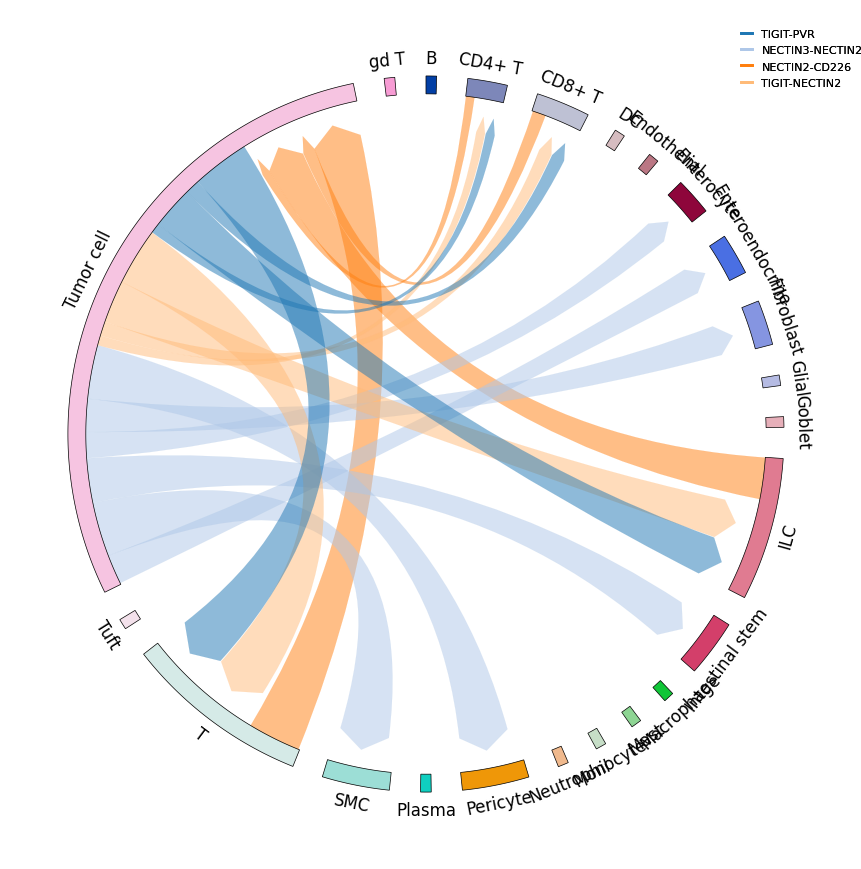

In [153]:
kpy.plot_cpdb_chord(
    adata=adata_tumor_cpdb,
    cell_type1="Tumor cell",
    cell_type2=".",
    means=means_e,
    pvals=pvals_e,
    deconvoluted=decon_e,
    celltype_key="Author_CellType_lvl_1b",
    interaction=["TIGIT-NECTIN2"],
    link_kwargs={"direction": 1, "allow_twist": False, "r1": 95, "r2": 90},
    sector_text_kwargs={"color": "black", "size": 12, "r": 105, "adjust_rotation": True},
    # legend_kwargs={'legend':None},
    # legend_kwargs={"loc": "center", "bbox_to_anchor": (1, 1), "fontsize": 0},
    link_offset=1,
)

In [ ]:
kpy.plot_cpdb_chord(
    adata=adata_tumor_cpdb,
    # cell_type1="Tumor cell",
    # cell_type2=".",
    means=means,
    pvals=pvals,
    deconvoluted=decon,
    celltype_key="Author_CellType_lvl_1b",
    # interaction=["PDCD1",],
    link_kwargs={"direction": 1, "allow_twist": False, "r1": 95, "r2": 90},
    sector_text_kwargs={"color": "black", "size": 12, "r": 105, "adjust_rotation": True},
    # legend_kwargs={'legend':None},
    legend_kwargs={"loc": "center", "bbox_to_anchor": (1, 1), "fontsize": 0},
    link_offset=1,
)

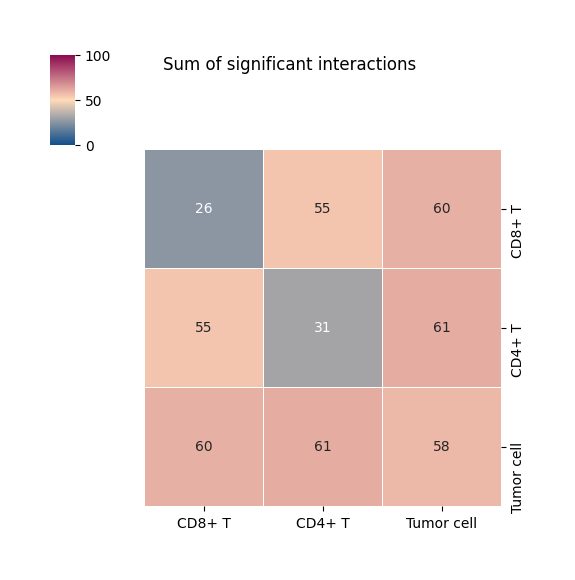

In [21]:
kpy.plot_cpdb_heatmap(pvals=pvals, cell_types=["Tumor cell", "CD8+ T", "CD4+ T",], vmin=0, vmax=100, annot=True, figsize=(5, 5), title="Sum of significant interactions",)


In [40]:
kpy.__version__

'0.2.4'

In [11]:
kpy.plot_cpdb_chord(
    adata=adata_tumor_cpdb,
    cell_type1="Tumor cell",
    cell_type2=".",
    means=means,
    pvals=pvals,
    deconvoluted=decon,
    celltype_key="celltype",
    interaction=["PTPRC", "CD40", "CLEC2D"],
    link_kwargs={"direction": 1, "allow_twist": True, "r1": 95, "r2": 90},
    sector_text_kwargs={"color": "black", "size": 12, "r": 105, "adjust_rotation": True},
    legend_kwargs={"loc": "center", "bbox_to_anchor": (1, 1), "fontsize": 8},
    link_offset=1,
)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/ktplotspy/plot/plot_cpdb.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


KeyboardInterrupt: 